# Plotting maps of a quantile value

Follow the steps below to use the quantile data set files to make a map of a particular quantile.

In this example, we plot the median Tmax averaged over all days in northern hemisphere summer.

In [1]:
# Necessary for reading and manipulating data
import xarray as xr  # used to load data and convenient coordinate manipulation.
import cftime  # used to create an artificial time coordinate with dates
import numpy as np  # used to create a lon/lat mesh

# Necessary for plot
import matplotlib as mpl  # plotting / used to make the normalized color mapping
import matplotlib.pyplot as plt  # used to make the plot
import cartopy.crs as ccrs  # used for mapping on specific projection
from cartopy.util import add_cyclic_point  # utility to add a wrap-around longitude point to avoid a gap in the plot


In [2]:
# open the observation data set and the model data set
ds_o = xr.open_dataset('/project/amp/brianpm/TemperatureExtremes/Derived/CPC_tmax_dayofyear_quantiles_15daywindow_c20190622.nc')
ds_m = xr.open_dataset('/project/amp/brianpm/TemperatureExtremes/Derived/f.e13.FAMIPC5CN.ne30_ne30.beta17.TREFMXAV.dayofyear_quantiles_15daywindow_c20190626.nc')

In [13]:
# define time coordinate variable for each data set because Brian forgot to do that when making the files
# Can use cftime directly to create generic "date" coordinate
ds_m['time'] = cftime.num2date(np.arange(365), "days since 0001-01-01", calendar='standard')
ds_o['time'] = cftime.num2date(np.arange(366), "days since 0001-01-01", calendar='standard')

In [16]:
# select a quantile to plot, let's say the median:
mdl_median = ds_m['TREFMXAV'].sel(quantile=0.5)
obs_median = ds_o['tmax'].sel(quantile=0.5)

In [27]:
# Let's average over Northern Summer -- JJA
# A. use the `sel` method to slice out June-July-August
# B. use the `mean` method to average over the sliced out times
mdl_median_jja = mdl_median.sel(time=slice('0001-06-01', '0001-08-30')).mean(dim='time')
obs_median_jja = obs_median.sel(time=slice('0001-06-01', '0001-08-30')).mean(dim='time')

/project/amp/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [29]:
# add wrap-around point  to avoid the white line along prime meridian
# the mdl_wrap and obs_wrap arrays are what we will actually plot
# the mdl_lon and obs_lon arrays should be identical, and are used to make the grid of lons
mdl_wrap, mdl_lon = add_cyclic_point(mdl_median_jja, coord=mdl_median['lon'])
obs_wrap, obs_lon = add_cyclic_point(obs_median_jja, coord=obs_median['lon'])


In [23]:
# they are on same grid, so only need one meshgrid:
lons, lats = np.meshgrid(mdl_lon, mdl_median['lat'])

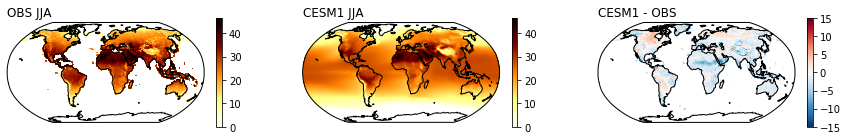

In [40]:
# Colors
# Set the min and max of all colors for use in setting the color scale.
# NOTE: model in K and obs in C, so have to apply conversion
vmin = 0.0 # min(i.min().values for i in [obs_median_jja, mdl_median_jja-273.15])
vmax = max(i.max().values for i in [obs_median_jja, mdl_median_jja-273.15])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
dnorm = mpl.colors.DivergingNorm(vmin=-15., vmax=15., vcenter=0.)

# Create Figure and Axes objects, and then fill Axes with pcolormesh plots
fig, ax = plt.subplots(ncols=3, figsize=(15,5), subplot_kw={"projection":ccrs.Robinson()})
img0 = ax[0].pcolormesh(lons, lats, obs_median_jja, cmap='afmhot_r', norm=norm, transform=ccrs.PlateCarree())
img1 = ax[1].pcolormesh(lons, lats, mdl_median_jja - 273.15, cmap='afmhot_r', norm=norm, transform=ccrs.PlateCarree())
img2 = ax[2].pcolormesh(lons, lats, mdl_median_jja - (obs_median_jja + 273.15), cmap='RdBu_r', norm=dnorm, transform=ccrs.PlateCarree())

ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

ax[0].set_title('OBS JJA', loc='left')
ax[1].set_title('CESM1 JJA', loc='left')
ax[2].set_title('CESM1 - OBS', loc='left')

fig.colorbar(img0, ax=ax[0], shrink=0.4)
fig.colorbar(img1, ax=ax[1], shrink=0.4)
fig.colorbar(img2, ax=ax[2], shrink=0.4)

In [31]:
obs_median_jja.max()

<xarray.DataArray 'tmax' ()>
array(46.384631)
Coordinates:
    quantile  float64 0.5